##Numpy and Scipy
* always try to move loops into np.... functions
* tilde (~) unary operator as in c[~np.isnan(c)] will give you all the values in c that are not nan

##First ML Application

In [4]:
url = 'https://raw.githubusercontent.com/goodwordalchemy/BuildingMachineLearningSystemsWithPython/master/ch01/data/web_traffic.tsv'
import requests
from io import BytesIO
import scipy as sp

r=requests.get(url)
data = sp.genfromtxt(BytesIO(r.content), delimiter='\t')
print(data[:10])
print (data.shape)

[[  1.00000000e+00   2.27200000e+03]
 [  2.00000000e+00              nan]
 [  3.00000000e+00   1.38600000e+03]
 [  4.00000000e+00   1.36500000e+03]
 [  5.00000000e+00   1.48800000e+03]
 [  6.00000000e+00   1.33700000e+03]
 [  7.00000000e+00   1.88300000e+03]
 [  8.00000000e+00   2.28300000e+03]
 [  9.00000000e+00   1.33500000e+03]
 [  1.00000000e+01   1.02500000e+03]]
(743, 2)


In [5]:
x = data[:,0]
y = data[:,1]
sp.sum(sp.isnan(y))

8

In [6]:
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

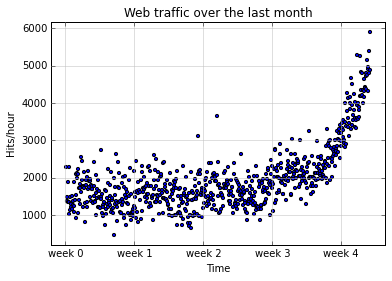

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_web_traffic():
    plt.scatter(x,y,s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")

    #the following sets the locations and names in the x-axis
    plt.xticks([w*7*24 for w in range(10)],
               ['week %i' % w for w in range(10)])
    plt.autoscale(tight=True)
    plt.grid(True, linestyle='-', color='0.75')
plot_web_traffic()

In [8]:
#for a learned model function f:
def error(f, x, y):
    return sp.sum((f(x)-y)**2)

fp1, residuals, rank, sv, rcond = sp.polyfit(x,y,1,full=True)
print('Model parameters: %s' %fp1)
print(residuals)

Model parameters: [   2.59619213  989.02487106]
[  3.17389767e+08]


In [9]:
f1 = sp.poly1d(fp1)
print(error(f1, x, y))

317389767.34


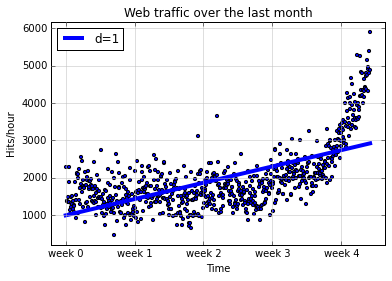

In [17]:
fx = sp.linspace(0, x[-1], 1000)
plot_web_traffic()
plt.plot(fx, f1(fx), linewidth=4)
plt.legend(['d=%i'%f1.order], loc='upper left')
plt.show()

degree: 1 317389767.34
degree: 2 179983507.878
degree: 3 139350144.032
degree: 10 121942326.363
degree: 53 109452403.681


/Users/davidgoldberg/anaconda/envs/py3k/lib/python3.3/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


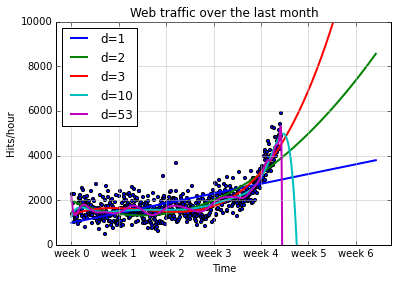

In [34]:
#fitting higher degrees:
def plot_higher_degrees():
    degrees = [1,2,3,10,53]
    fx = sp.linspace(0, x[-1]+24*7*2, 1000)
    plot_web_traffic()
    for d in degrees:
        fp = sp.polyfit(x,y,d)
        f = sp.poly1d(fp)
        print('degree:',d,error(f, x, y))
        
        plt.plot(fx, f(fx), linewidth=2, label='d=%d'%f.order)
    plt.ylim(0,10000)
    plt.legend(loc='upper left')
plot_higher_degrees()
plt.show()

Error inflection=132950348.197616


[]

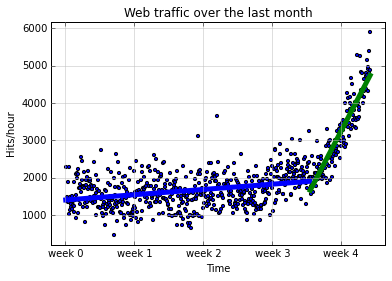

In [29]:
#separating data at inflection point ~3.5 weeks
inflection = 3.5*7*24
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)
print("Error inflection=%f" % (fa_error + fb_error))

plot_web_traffic()
fxa = sp.linspace(xa[0], xa[-1], 500)
fxb = sp.linspace(xb[0], xb[-1], 500)
plt.plot(fxa, fa(fxa), linewidth=5)
plt.plot(fxb, fb(fxb), linewidth=5)
plt.plot()

* underfit data might capture future data better

###Training and Testing
We can't look into the future, but we can remove a certain percentage of the data and train on the remaining part.  Use the held-out set to calculate the rror


Error d=1: 1.8e+07
Error d=2: 1.7e+07
Error d=3: 1.8e+07
Error d=10: 2.8e+07
Error d=53: 1.3e+09


/Users/davidgoldberg/anaconda/envs/py3k/lib/python3.3/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/davidgoldberg/anaconda/envs/py3k/lib/python3.3/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


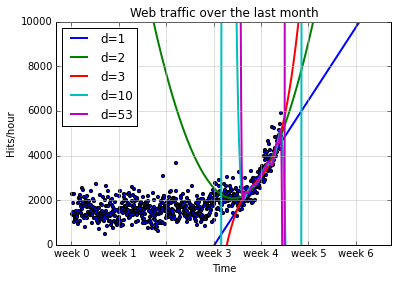

In [44]:
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = sp.random.permutation(list(range(len(xb))))
test = sorted(shuffled[split_idx:])
train = sorted(shuffled[:split_idx])
plot_web_traffic()
fx = sp.linspace(0, x[-1]+24*7*2, 1000)
for d in degrees:
    f = sp.poly1d(sp.polyfit(xb[train], yb[train],d))
    print("Error d=%d: %0.2g"%(d,error(f, xb[test], yb[test])))
    plt.plot(fx, f(fx), linewidth=2, label="d=%d"%d)
plt.ylim(0,10000)
plt.legend(loc='upper left')
plt.show()


In [53]:
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))
print(fbt2-100000)
from scipy.optimize import fsolve
reached_max = fsolve(fbt2-100000, x0=800)/(7*24)
print("100000 hits/hour expected at week %f"%reached_max[0])

        2
0.0988 x - 113.4 x - 6.537e+04
100000 hits/hour expected at week 9.342779


##Conclusions:
* understand your data
* correct experiment setup - training and testing